# Train/Dev/Test split using AotM-2011 Playlists & MSD Audio Features

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import gzip
import pickle as pkl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import lil_matrix, issparse

import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data_dir = 'data/aotm-2011'
#faotm = os.path.join(data_dir, 'aotm2011-subset.pkl')
faotm = os.path.join(data_dir, 'aotm2011-user-playlist.pkl')
ffeature = 'data/msd/song2feature.pkl.gz'
fgenre = 'data/msd/song2genre.pkl'

## Data loading

Load playlists.

In [5]:
user_playlists = pkl.load(open(faotm, 'rb'))

In [6]:
print('#user    :', len(user_playlists))
print('#playlist:', np.sum([len(user_playlists[u]) for u in user_playlists]))

#user    : 14182
#playlist: 84710


In [7]:
song_set = sorted({sid for u in user_playlists for pl in user_playlists[u] for sid in pl})

In [8]:
song2genre = pkl.load(open(fgenre, 'rb'))

In [13]:
nogenre = []
for sid in song_set:
    if sid not in song2genre:
        nogenre.append(sid)
print('%.1f%% of all songs do not have genre' % (100 * len(nogenre) / len(song_set)))

49.8% of all songs do not have genre


In [14]:
users = sorted(user_playlists.keys())

In [15]:
user_playlists[users[0]][0]

['SOEURWZ12A58A7B772',
 'SOGVEJN12A6D4F9D83',
 'SOUNSZA12A8C13A204',
 'SOXLLMC12A8C13E499',
 'SOQPSMN12AB0184EDA',
 'SOKAWWA12A6701FD46']

In [16]:
pl_lengths = [len(pl) for u in user_playlists for pl in user_playlists[u]]
#plt.hist(pl_lengths, bins=100)
print('Average playlist length: %.1f' % np.mean(pl_lengths))

Average playlist length: 10.1


In [17]:
np.sum(np.array(pl_lengths) >= 5)

84710

In [18]:
np.sum(pl_lengths)

857782

In [19]:
np.sum([len(set(pl)) for u in user_playlists for pl in user_playlists[u]])

857782

In [20]:
(np.min(pl_lengths), np.max(pl_lengths), float('%.1f' % np.mean(pl_lengths)))

(5, 45, 10.1)

Load song features.

Load `song_id` --> `feature array` mapping: map a song to the audio features of one of its corresponding tracks in MSD.

In [21]:
song2Features = pkl.load(gzip.open(ffeature, 'rb'))

The set of songs, which is the set of labels in this formulation.

In [22]:
#song_set = sorted(song2Features.keys())  # use MSD songs as label space
# use the intersection of MSD and AotM as label space
song_set = sorted({sid for u in user_playlists for pl in user_playlists[u] for sid in pl})   

In [23]:
len(song_set)

114428

## Song-User Matrix

Transpose the user-song matrix to song-user matrix: songs as rows, users as columns, split rows.

In [24]:
def gen_songuser_mat(user_playlists, song_set, features_MSD):
    """
    Create labelled dataset: rows are songs, columns are users.
    
    Input:
        - user_playlists: dictionary that maps users to a set of playlists
        - song_set: a set of songIDs
        - features_MSD: dictionary that maps songIDs to features from MSD
    Output:
        - (Feature, Label) pair (X, Y)
          X: #songs by #features
          Y: #songs by #users
    """
    user_set = sorted(user_playlists.keys())
    song_indices = {sid: ix for ix, sid in enumerate(song_set)}
    N = len(song_set)
    K = len(user_set)
    
    X = np.array([features_MSD[sid] for sid in song_set])
    Y = lil_matrix((N, K), dtype=np.bool)
    
    for k in range(K):
        if (k+1) % 1000 == 0:
            sys.stdout.write('\r%d / %d' % (k+1, K))
            sys.stdout.flush()
            
        u = user_set[k]
        songs = sorted({sid for pl in user_playlists[u] for sid in pl})
        indices = [song_indices[sid] for sid in songs]
        Y[indices, k] = 1

    return X, Y.tocsr()

In [25]:
X, Y = gen_songuser_mat(user_playlists=user_playlists, song_set=song_set, features_MSD=song2Features)

14000 / 14182

In [26]:
pop = np.sum(Y, axis=1)

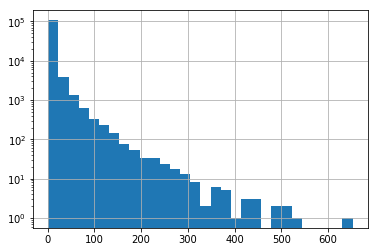

In [62]:
ax = plt.subplot(111)
pd.Series(np.array(pop).flatten()).hist(ax=ax, bins=30)
#ax.hist(sorted(pop.tolist()))
ax.set_yscale('log')
#ax.set_xscale('log')

In [38]:
np.max(pop)

653

In [39]:
np.min(pop)

1

In [21]:
fdir = os.path.join(data_dir, 'song_user')
fx      = os.path.join(fdir, 'X.pkl')
fy      = os.path.join(fdir, 'Y.pkl')
fxtrain = os.path.join(fdir, 'X_train.pkl')
fytrain = os.path.join(fdir, 'Y_train.pkl')
fxdev   = os.path.join(fdir, 'X_dev.pkl')
fydev   = os.path.join(fdir, 'Y_dev.pkl')

In [22]:
if np.all([os.path.exists(fname) for fname in [fx, fy, fxtrain, fytrain, fxdev, fydev]]):
    X       = pkl.load(open(fx,      'rb'))
    Y       = pkl.load(open(fy,      'rb'))
    X_train = pkl.load(open(fxtrain, 'rb'))
    Y_train = pkl.load(open(fytrain, 'rb'))
    X_dev   = pkl.load(open(fxdev,   'rb'))
    Y_dev   = pkl.load(open(fydev,   'rb'))
else:
    # generate dataset
    X, Y = gen_songuser_mat(user_playlists=user_playlists, song_set=song_set, features_MSD=song2Features)
    
    # data split: approximately 80/20 for training/dev
    X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.2, random_state=123456789)
    
    # feature normalisation
    X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
    X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
    X_train -= X_train_mean
    X_train /= X_train_std
    X_dev   -= X_train_mean
    X_dev   /= X_train_std
    
    # save to files
    pkl.dump(X,       open(fx, 'wb'))
    pkl.dump(Y,       open(fy, 'wb'))
    pkl.dump(X_train, open(fxtrain, 'wb'))
    pkl.dump(Y_train, open(fytrain, 'wb'))
    pkl.dump(X_dev,   open(fxdev,   'wb'))
    pkl.dump(Y_dev,   open(fydev,   'wb'))

14000 / 14182

In [23]:
print('All  : %15s %15s' % (X.shape, Y.shape))
print('Train: %15s %15s' % (X_train.shape, Y_train.shape))
print('Dev  : %15s %15s' % (X_dev.shape,   Y_dev.shape))

All  :   (114428, 202) (114428, 14182)
Train:    (91542, 202)  (91542, 14182)
Dev  :    (22886, 202)  (22886, 14182)


In [24]:
np.mean(np.mean(X_train, axis=0))

-5.744088163228033e-15

In [25]:
np.mean(np.std(X_train, axis=0)) - 1

-0.019815081566402215

In [26]:
np.mean(np.mean(X_dev, axis=0))

-0.0005716163590059731

In [27]:
np.mean(np.std(X_dev, axis=0)) - 1

-0.0354526080921741

## Playlist-Song Matrix

The playlist-song matrix: playlists as rows, songs as columns, split rows.

- For users with more than 10 playlists, we split their playlists approximately 70/10/20 for train/dev/test.
- For each playlist in dev/test set, we remove the last 20% and try to predict them.
- All remaining playlists are used for training as well.

In [ ]:
list(label_indices.items())[:10]

In [ ]:
def gen_training_set(playlists, label_indices, features):
    """
        Create the labelled dataset: rows are playlists, columns are songs
        
        Input:
            - playlists: which playlists to create features for
            - label_indices: a dictionary that maps a songID to the index of the corresponding label
            - features: a dictionary that maps a songID to its feature vector
            
        Output:
            - (Feature, Label) pair (X, Y), with # num playlists rows
              X comprises the features for each seed song (the 1st in playlist)
              Y comprises the indicators of whether the given song is present in the respective playlist
    """

    N = len(playlists)
    K = len(label_indices)

    X = [ ]
    Y = lil_matrix((N, K), dtype=np.int8)
    
    cnt = 0
    for i in range(len(playlists)):
        cnt += 1
        if cnt % 1000 == 0:
            sys.stdout.write('\r%d / %d' % (cnt, len(playlists)))
            sys.stdout.flush()
            
        playlist = playlists[i]
        seed     = playlist[0]

        X.append(features[seed])
        #indices = [label_indices[s] for s in playlist]
        indices = [label_indices[s] for s in playlist if s in label_indices]
        Y[i, indices] = 1

    return np.array(X), Y.tocsr()

In [ ]:
#test_dict = {1: 0, 2: 1, 3: 2}
#[test_dict[s] for s in [1, 2, 5] if s in test_dict]

In [ ]:
fdir = os.path.join(data_dir, 'setting1')
fxtrain = os.path.join(fdir, 'X_train_audio.pkl')
fytrain = os.path.join(fdir, 'Y_train_audio.pkl')
fxdev   = os.path.join(fdir, 'X_dev_audio.pkl')
fydev   = os.path.join(fdir, 'Y_dev_audio.pkl')
fxtest  = os.path.join(fdir, 'X_test_audio.pkl')
fytest  = os.path.join(fdir, 'Y_test_audio.pkl')

In [ ]:
if np.all([os.path.exists(fname) for fname in [fxtrain, fytrain, fxdev, fydev, fxtest, fytest]]):
    X_train = pkl.load(open(fxtrain, 'rb'))
    Y_train = pkl.load(open(fytrain, 'rb'))
    X_dev   = pkl.load(open(fxdev,   'rb'))
    Y_dev   = pkl.load(open(fydev,   'rb'))
    X_test  = pkl.load(open(fxtest,  'rb'))
    Y_test  = pkl.load(open(fytest,  'rb'))
else:
    # generate dataset
    X, Y = gen_training_set(playlists=playlists, label_indices=label_indices, features=song2Features)
    
    # data split: approximately 70/10/20 for training/dev/test
    # by fixing random seed, the same playlists will be in the test set each time
    X_train, X_other, Y_train, Y_other = train_test_split(X, Y, test_size=0.3, random_state=123456789)
    X_dev,   X_test,  Y_dev,   Y_test  = train_test_split(X_other, Y_other, test_size=0.65, random_state=987654321)
    
    # feature normalisation
    X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
    X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
    X_train -= X_train_mean
    X_train /= X_train_std
    X_dev   -= X_train_mean
    X_dev   /= X_train_std
    X_test  -= X_train_mean
    X_test  /= X_train_std
    
    # save to files
    pkl.dump(X_train, open(fxtrain, 'wb'))
    pkl.dump(Y_train, open(fytrain, 'wb'))
    pkl.dump(X_dev,   open(fxdev,   'wb'))
    pkl.dump(Y_dev,   open(fydev,   'wb'))
    pkl.dump(X_test,  open(fxtest,  'wb'))
    pkl.dump(Y_test,  open(fytest,  'wb'))

In [ ]:
print('Train: %15s %15s' % (X_train.shape, Y_train.shape))
print('Dev  : %15s %15s' % (X_dev.shape,   Y_dev.shape))
print('Test : %15s %15s' % (X_test.shape,  Y_test.shape))

In [ ]:
np.mean(np.mean(X_train, axis=0))

In [ ]:
np.mean(np.std(X_train, axis=0)) - 1

In [ ]:
np.mean(np.mean(X_dev, axis=0))

In [ ]:
np.mean(np.std(X_dev, axis=0)) - 1

In [ ]:
np.mean(np.mean(X_test, axis=0))

In [ ]:
np.mean(np.std(X_test, axis=0)) - 1

## Setting 2

A set of playlists as labels.

In [ ]:
def gen_training_set2(playlists, features):
    """
        Create the labelled dataset: rows are songs, columns are playlists
        
        Input:
            - playlists: which playlists to create features for
            - features: a dictionary that maps a songID to its feature vector
            
        Output:
            - (Feature, Label) pair (X, Y), with # num playlists rows
              X comprises the features for each song
              Y comprises the indicators of whether the given song is present in the respective playlist
    """
    
    song_set = sorted({sid for pl in playlists for sid in pl})
    songInPlaylist = {sid: [] for sid in song_set}
    N = len(song_set)
    K = len(playlists)

    for j in range(K):
        pl = playlists[j]
        for sid in pl:
            songInPlaylist[sid].append(j)
    
    X = [ ]
    Y = lil_matrix((N, K), dtype=np.int8)
    for i in range(N):
        if (i+1) % 1000 == 0:
            sys.stdout.write('\r%d / %d' % (i+1, N))
            sys.stdout.flush()
        sid = song_set[i]
        X.append(features[sid])
        indices = songInPlaylist[sid]
        Y[i, indices] = 1
        
    return np.array(X), Y.tocsr()

In [ ]:
fdir = os.path.join(data_dir, 'setting2')
fxtrain = os.path.join(fdir, 'X_train_audio.pkl')
fytrain = os.path.join(fdir, 'Y_train_audio.pkl')
fxdev   = os.path.join(fdir, 'X_dev_audio.pkl')
fydev   = os.path.join(fdir, 'Y_dev_audio.pkl')
fxtest  = os.path.join(fdir, 'X_test_audio.pkl')
fytest  = os.path.join(fdir, 'Y_test_audio.pkl')

In [ ]:
if np.all([os.path.exists(fname) for fname in [fxtrain, fytrain, fxdev, fydev, fxtest, fytest]]):
    X_train = pkl.load(open(fxtrain, 'rb'))
    Y_train = pkl.load(open(fytrain, 'rb'))
    X_dev   = pkl.load(open(fxdev,   'rb'))
    Y_dev   = pkl.load(open(fydev,   'rb'))
    X_test  = pkl.load(open(fxtest,  'rb'))
    Y_test  = pkl.load(open(fytest,  'rb'))
else:
    # generate dataset
    X, Y = gen_training_set2(playlists=playlists, features=song2Features)

    # data split: approximately 70/10/20 for training/dev/test
    # by fixing random seed, the same playlists will be in the test set each time
    X_train, X_other, Y_train, Y_other = train_test_split(X, Y, test_size=0.3, random_state=59)
    X_dev,   X_test,  Y_dev,   Y_test  = train_test_split(X_other, Y_other, test_size=0.65, random_state=71)

    # feature normalisation
    X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
    X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
    X_train -= X_train_mean
    X_train /= X_train_std
    X_dev   -= X_train_mean
    X_dev   /= X_train_std
    X_test  -= X_train_mean
    X_test  /= X_train_std

    # save to files
    pkl.dump(X_train, open(fxtrain, 'wb'))
    pkl.dump(Y_train, open(fytrain, 'wb'))
    pkl.dump(X_dev,   open(fxdev,   'wb'))
    pkl.dump(Y_dev,   open(fydev,   'wb'))
    pkl.dump(X_test,  open(fxtest,  'wb'))
    pkl.dump(Y_test,  open(fytest,  'wb'))

In [ ]:
print('Train: %15s %15s' % (X_train.shape, Y_train.shape))
print('Dev  : %15s %15s' % (X_dev.shape,   Y_dev.shape))
print('Test : %15s %15s' % (X_test.shape,  Y_test.shape))

In [ ]:
Y.sum()

In [ ]:
np.mean(np.mean(X_train, axis=0))

In [ ]:
np.mean(np.std(X_train, axis=0)) - 1

In [ ]:
np.mean(np.mean(X_dev, axis=0))

In [ ]:
np.mean(np.std(X_dev, axis=0)) - 1

In [ ]:
np.mean(np.mean(X_test, axis=0))

In [ ]:
np.mean(np.std(X_test, axis=0)) - 1

### Statistics

Song in playlist.

In [ ]:
song_set = sorted({sid for pl in playlists for sid in pl})
songInPlaylist = {sid: [] for sid in song_set}
K = len(playlists)
for j in range(K):
    pl = playlists[j]
    for sid in pl: songInPlaylist[sid].append(j)

In [ ]:
S_train, S_other, dummy_train, dummy_other = train_test_split(song_set, np.arange(len(song_set)), 
                                                              test_size=0.3, random_state=59)
S_dev, S_test, dummy_dev, dummy_test = train_test_split(S_other, dummy_other, test_size=0.65, random_state=71)

In [ ]:
len(S_train)

In [ ]:
len(S_test)

In [ ]:
ix = 0
sid = S_train[ix]
#np.equal(song2Features[sid], X_train[ix])

In [ ]:
songInPlaylist[song_set[dummy_train[0]]]

In [ ]:
np.nonzero()

In [ ]:
f1 = pd.read_csv('data/f1.txt', names=['F1', '0'])

In [ ]:
f1 = f1['F1']

In [ ]:
pak = pd.read_csv('data/pak.txt', names=['PaK', '0'])
pak = pak['PaK']

In [ ]:
xmin = np.min([np.min(f1), np.min(pak)]) - 0.00005
xmax = np.max([np.max(f1), np.max(pak)]) + 0.00005
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.plot([xmin, xmax], [xmin, xmax], ls='--', c='g')
plt.scatter(f1, pak)
plt.xlabel('F1')
plt.ylabel('Precision@K')